In [5]:
import pandas as pd
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt


In [6]:
folder_path = './metagenomic_individual_data'  # Replace with the actual path to your folder

# Use glob to find all files named "train_dev.tsv" and "devel.tsv" within the folder
train_file_paths = glob.glob(folder_path + '/**/train_dev.tsv', recursive=True)
dev_file_paths = glob.glob(folder_path + '/**/devel.tsv', recursive=True)


In [7]:
# Print the paths of the found files
print("Train Files:")
for file_path in train_file_paths:
    print(file_path)

print("\nDev Files:")
for file_path in dev_file_paths:
    print(file_path)


Train Files:
./metagenomic_individual_data/metagenomics_dataset/place/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/state/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/primer/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/treatment/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/gene/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/site/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/body-site/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/kit/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/engineered/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/LS/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/sequencing/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/date/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/host/train_dev.tsv
./metagenomic_individual_data/metagenomics_dataset/eco

In [8]:
# Function to load and concatenate columns from multiple TSV files into a DataFrame
def load_tsv_files(file_paths):
    data_frame = pd.DataFrame()
    for file_path in file_paths:
        temp_df = pd.read_csv(file_path, sep='\t', names=['token', 'entity'], skip_blank_lines=False, na_filter=False)
        column_name = file_path.split('/')[-2]
        column_data = temp_df['entity']
        data_frame[column_name] = column_data
    
    tokens_column = temp_df['token']
    data_frame.insert(0, 'token', tokens_column)
    
    return data_frame

# Load train and development sets
train_data = load_tsv_files(train_file_paths)
dev_data = load_tsv_files(dev_file_paths)

In [9]:
train_data

,token,place,state,primer,treatment,gene,site,body-site,kit,engineered,LS,sequencing,date,host,ecoregion,sample-material,LCM
0,Methods,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
1,Sediment,O,O,O,O,O,B,O,O,O,O,O,O,O,O,B,O
2,core,O,O,O,O,O,I,O,O,O,O,O,O,O,O,I,O
3,sample,O,O,O,O,O,O,O,O,O,O,O,O,O,O,I,O
4,In,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90823,",",O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
90824,CA,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
90825,),O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
90826,.,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


In [18]:
import pandas as pd
from tqdm import tqdm

def transform_dataframe(df):
    """
    Transforms a DataFrame with IOB NER labels for multiple entity types.
    Assigns 'O' for non-entity tokens, handles sentence breaks by assigning empty strings,
    and resets entity tracking at sentence boundaries.

    Parameters:
    df (pd.DataFrame): DataFrame with a 'token' column and one or more entity columns.

    Returns:
    pd.DataFrame: Transformed DataFrame with tokens and IOB NER tags.
    """
    ner_data = []
    cols = df.columns[1:]  # Exclude the 'token' column

    # Initialize previous_tag for each entity type to track ongoing entities
    previous_tag = {col: 'O' for col in cols}

    for row in tqdm(df.itertuples(index=False), total=len(df), desc="Processing rows"):
        token = row[0]  # Assuming 'token' is the first column

        if token == '':
            # Sentence break: set 'ner' to empty string and reset previous_tag
            ner = ''
            previous_tag = {col: 'O' for col in cols}
        else:
            ner = 'O'  # Default NER tag is 'O' (Outside)

            for idx, col in enumerate(cols, start=1):
                value = row[idx]
                
                if value not in ['B', 'I', 'O']:
                    raise ValueError(f"Invalid tag '{value}' in column '{col}'")

                if value == 'B':
                    ner = f'B-{col}'
                    previous_tag[col] = 'B'
                    break  # Assign only one NER label per token
                elif value == 'I' and previous_tag[col] in ['B', 'I']:
                    ner = f'I-{col}'
                    previous_tag[col] = 'I'
                    break
                else:
                    previous_tag[col] = 'O'

        ner_data.append({'token': token, 'ner': ner})

    ner_df = pd.DataFrame(ner_data)
    return ner_df


In [19]:
# Transform datasets
set1_train = transform_dataframe(train_data[['token', 'body-site', 'ecoregion', 'engineered', 'sequencing']])
set2_train = transform_dataframe(train_data[['token', 'treatment', 'site']])
set3_train = transform_dataframe(train_data[['token', 'LCM', 'date', 'place', 'host']])
set4_train = transform_dataframe(train_data[['token', 'sample-material', 'LS', 'gene']])
set5_train = transform_dataframe(train_data[['token', 'kit', 'state', 'primer']])

# Similarly for development sets
set1_dev = transform_dataframe(dev_data[['token', 'body-site', 'ecoregion', 'engineered', 'sequencing']])
set2_dev = transform_dataframe(dev_data[['token', 'treatment', 'site']])
set3_dev = transform_dataframe(dev_data[['token', 'LCM', 'date', 'place', 'host']])
set4_dev = transform_dataframe(dev_data[['token', 'sample-material', 'LS', 'gene']])
set5_dev = transform_dataframe(dev_data[['token', 'kit', 'state', 'primer']])


Processing rows: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10366/10366 [00:00<00:00, 324917.27it/s]


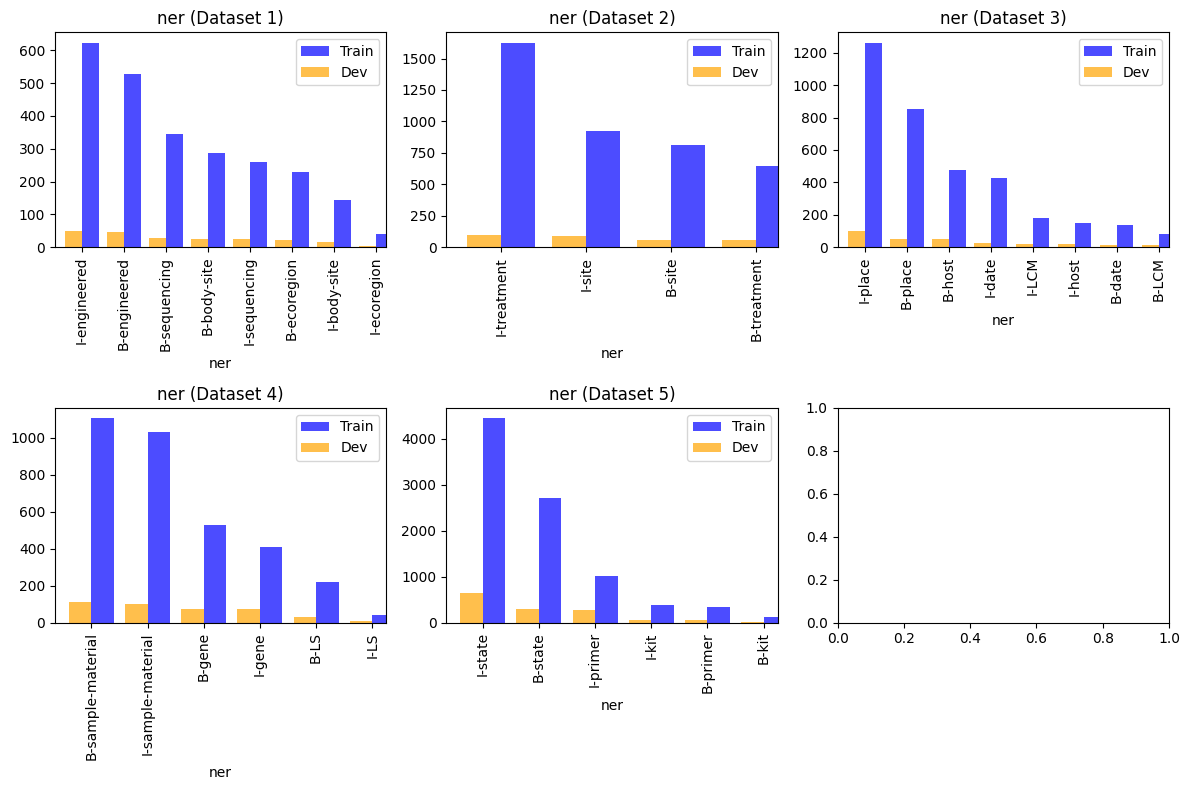

In [20]:
import matplotlib.pyplot as plt

def plot_datasets(train_datasets, dev_datasets, label_to_remove='O', rows=3, cols=2):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()

    for i, (train_df, dev_df) in enumerate(zip(train_datasets, dev_datasets)):
        for column in train_df.columns:
            if column == 'token':
                continue  # Skip the 'token' column

            # Get value counts for both train and dev sets
            train_unique_values = train_df[column].value_counts()
            dev_unique_values = dev_df[column].value_counts()

            # Remove the 'O' label and empty strings
            if label_to_remove in train_unique_values:
                train_unique_values = train_unique_values.drop(label_to_remove)
            if '' in train_unique_values:
                train_unique_values = train_unique_values.drop('')

            if label_to_remove in dev_unique_values:
                dev_unique_values = dev_unique_values.drop(label_to_remove)
            if '' in dev_unique_values:
                dev_unique_values = dev_unique_values.drop('')

            # Plot both train and dev on the same subplot
            ax = axes[i]
            if len(train_unique_values) <= 10:
                train_unique_values.plot(kind='bar', ax=ax, color='blue', alpha=0.7, position=0, width=0.4, label='Train')
                dev_unique_values.plot(kind='bar', ax=ax, color='orange', alpha=0.7, position=1, width=0.4, label='Dev')
            else:
                train_df[column].plot(kind='hist', ax=ax, color='blue', alpha=0.7, label='Train')
                dev_df[column].plot(kind='hist', ax=ax, color='orange', alpha=0.7, label='Dev')

            ax.set_title(f'{column} (Dataset {i+1})')
            ax.legend()

    plt.tight_layout()
    plt.show()

# Combine all training and development sets for plotting
train_sets = [set1_train, set2_train, set3_train, set4_train, set5_train]
dev_sets = [set1_dev, set2_dev, set3_dev, set4_dev, set5_dev]

# Plot both train and dev sets together
plot_datasets(train_sets, dev_sets, rows=2, cols=3)


In [21]:
set1_dev['ner'].unique()

array(['O', '', 'B-engineered', 'B-sequencing', 'I-sequencing',
       'I-engineered', 'B-ecoregion', 'B-body-site', 'I-body-site',
       'I-ecoregion'], dtype=object)

In [22]:
def check_data_integrity(df):
    """
    Function to check the integrity of NER data.
    Ensures:
    1. Each 'B-ent' is followed by its respective 'I-ent' (if applicable).
    2. No 'I-ent' appears without a preceding 'B-ent'.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the NER columns with tokens and entities.
    
    Returns:
    bool: True if the data integrity is intact, False if there are issues.
    issues (list): List of issues found in the dataset.
    """
    issues = []
    cols = df.columns[1:]  # Exclude the 'token' column

    for col in cols:
        found_b_ent = False
        for i, entity in enumerate(df[col]):
            if entity.startswith('B-'):
                found_b_ent = True
            elif entity.startswith('I-'):
                if not found_b_ent:
                    issues.append(f"Column: {col}, Row: {i}, Hanging I-ent without preceding B-ent.")
                # Check if the current I-ent is the right continuation of a B-ent
                elif not entity[2:] == df[col].iloc[i-1][2:]:
                    issues.append(f"Column: {col}, Row: {i}, Mismatch between B-ent and I-ent.")

            # Reset B-ent flag if it's an 'O' or empty string
            if entity == 'O' or entity == '':
                found_b_ent = False

    if not issues:
        return True, []
    else:
        return False, issues

# Function to check integrity of both train and development sets
def check_integrity_of_sets(train_sets, dev_sets):
    """
    Check the integrity of NER train and development sets for each dataset.
    
    Parameters:
    train_sets (list): List of training datasets.
    dev_sets (list): List of development datasets.
    
    Returns:
    None: Prints the integrity check results for each set.
    """
    for i, (train_df, dev_df) in enumerate(zip(train_sets, dev_sets)):
        print(f"\nChecking Dataset {i+1}:")
        
        # Check train set
        is_train_valid, train_issues = check_data_integrity(train_df)
        if is_train_valid:
            print(f"Train set {i+1} is valid.")
        else:
            print(f"Train set {i+1} has issues:\n", "\n".join(train_issues))
        
        # Check dev set
        is_dev_valid, dev_issues = check_data_integrity(dev_df)
        if is_dev_valid:
            print(f"Dev set {i+1} is valid.")
        else:
            print(f"Dev set {i+1} has issues:\n", "\n".join(dev_issues))

# Example usage
check_integrity_of_sets(train_sets, dev_sets)



Checking Dataset 1:
Train set 1 is valid.
Dev set 1 is valid.

Checking Dataset 2:
Train set 2 is valid.
Dev set 2 is valid.

Checking Dataset 3:
Train set 3 is valid.
Dev set 3 is valid.

Checking Dataset 4:
Train set 4 is valid.
Dev set 4 is valid.

Checking Dataset 5:
Train set 5 is valid.
Dev set 5 is valid.


In [24]:
import os

# Function to save the DataFrame as a TSV file
def save_tsv(df, folder, name):
    """
    Save the DataFrame to a TSV file.
    
    Parameters:
    df (pd.DataFrame): DataFrame to save.
    folder (str): Folder path where the file will be saved.
    name (str): Name of the file (without extension).
    """
    os.makedirs(folder, exist_ok=True)  # Create the folder if it doesn't exist
    path = os.path.join(folder, f"{name}.tsv")
    df.to_csv(path, sep='\t', index=False, header=False)

# Create base folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Define folder names for each set
sets = ['set1', 'set2', 'set3', 'set4', 'set5']

# Save train sets
save_tsv(set1_train, os.path.join(folder_path, "set1"), "train")
save_tsv(set2_train, os.path.join(folder_path, "set2"), "train")
save_tsv(set3_train, os.path.join(folder_path, "set3"), "train")
save_tsv(set4_train, os.path.join(folder_path, "set4"), "train")
save_tsv(set5_train, os.path.join(folder_path, "set5"), "train")

# Save dev sets
save_tsv(set1_dev, os.path.join(folder_path, "set1"), "dev")
save_tsv(set2_dev, os.path.join(folder_path, "set2"), "dev")
save_tsv(set3_dev, os.path.join(folder_path, "set3"), "dev")
save_tsv(set4_dev, os.path.join(folder_path, "set4"), "dev")
save_tsv(set5_dev, os.path.join(folder_path, "set5"), "dev")
